# Project 07. Time Series Analysis - Temperature forecast 

## 1. Defining porject goal

Building a model that can predict temperature for the upcoming days, given the temprature until today, as precisely as possible.

## 2. Imports

In [1]:
# plotting, eda
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Analysis
import statsmodels.tsa.stattools as tsa # adf
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg

# Model
import statsmodels
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

## 3. Getting Data

### 3.1. Loading Data

In [2]:
# creating dataframe: opening txt file, transforming it to csv, skipping the first 19 rows, setting first column as index, and setting it as DateTimeIndex
df = pd.read_csv('data/TG_STAID004586.txt', skiprows=19, index_col=1, parse_dates=True)

In [3]:
df.head()

,SOUID,TG,Q_TG
DATE,,,
1979-01-01,111448,-119,0
1979-01-02,111448,-93,0
1979-01-03,111448,-78,0
1979-01-04,111448,-96,0
1979-01-05,111448,-99,0


### 3.2. Cleaning Data

In [4]:
print(df.columns)

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')


In [5]:
# dropping unnecessary columns
df.drop([' SOUID', ' Q_TG'], axis=1, inplace=True)

In [6]:
# renaming 
df.rename(columns={'   TG': 'temperature'}, inplace=True)

In [7]:
print(df.columns, df.index)

Index(['temperature'], dtype='object') DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='    DATE', length=15341, freq=None)


In [8]:
df.index.names = ['date']

In [9]:
print(df.columns, df.index)

Index(['temperature'], dtype='object') DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=15341, freq=None)


In [10]:
# setting temperature decimal for easier interpretation 
df['temperature'] = df['temperature'] / 10

In [11]:
df.head()

,temperature
date,
1979-01-01,-11.9
1979-01-02,-9.3
1979-01-03,-7.8
1979-01-04,-9.6
1979-01-05,-9.9


In [12]:
# checking for NaN values 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15341 entries, 1979-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  15341 non-null  float64
dtypes: float64(1)
memory usage: 239.7 KB


In [13]:
df.isna().sum()

temperature    0
dtype: int64

## 4. Data Split

In [14]:
# df is downsized for faster training. df includes the last 10 years. This will be still split to train-test data later. 
# apart from the last week, we will use this one week for prediction with model.forecast
df_forecast = df[-31:]
df = df[-3653:-31]


In [15]:
df.head()

,temperature
date,
2011-01-01,2.7
2011-01-02,0.6
2011-01-03,-1.5
2011-01-04,-1.6
2011-01-05,-5.8


In [16]:
# we will apply the model.forecast on this data 
df_forecast.head()

,temperature
date,
2020-12-01,2.4
2020-12-02,-0.9
2020-12-03,-0.7
2020-12-04,1.4
2020-12-05,3.6


## 5. Visualizing Data - Trend, Seasonality, Remainder

In [17]:
fig1 = px.line(df, y=df["temperature"], 
               title="Daily mean of temperature in Berlin-Treptow between 2011.01.01-2020.12.24",
               labels={ # replaces default labels by column name
                "date": "Year",  "temperature": "Temperature (Celcius degree)"},
              )
fig1.update_layout(title_x=0.5, height=600)
fig1.show()

### 5.1. Trend

In [18]:
df['timestep'] = range(len(df))

In [19]:
X_trend = df[['timestep']]
y = df['temperature']

In [20]:
m = LinearRegression()

In [21]:
m.fit(X_trend, y)

LinearRegression()

In [22]:
df['trend'] = m.predict(X_trend)

In [23]:
fig_trend1 = go.Figure()

fig_trend1.add_trace(go.Scatter(x=df.index.values, y=df['temperature'], name='Temperature'))
fig_trend1.update_layout(title_text='Trend with linear regression',
                  title_x=0.5,
                  height=600,
                  xaxis_title="Date", 
                  yaxis_title="Temperature (Celcius)")
fig_trend1.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Trend'))

fig_trend1.show()

In [24]:
# plotting linear regression with px.scatter trendline=ols parameter

fig_trend2 = px.scatter(df, x=df.index, y="temperature", 
                  color='temperature', 
                  trendline="ols", #lowess, expanding
                  trendline_color_override="red", 
                  title="Trendline with OLS",
                  labels={"date": "Year",  "temperature": "Temperature"})
fig_trend2.update_layout(
    title={'x':0.5},
    xaxis_title="Date", 
    yaxis_title="Temperature (Celcius)",
    height=600)
fig_trend2.show()

### 5.2. Seasonality

In [25]:
# creating dummy features for each months.
month_dummies = pd.get_dummies(df.index.month, drop_first=True, prefix='month').set_index(df.index)

In [26]:
df = df.join(month_dummies)

In [27]:
# using the timestep feature and the seasonal dummies as X
X_seasonal = df.drop(['temperature', 'trend'], axis=1)

In [28]:
X_seasonal


,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2011-01-01,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2011-01-03,2,0,0,0,0,0,0,0,0,0,0,0
2011-01-04,3,0,0,0,0,0,0,0,0,0,0,0
2011-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,3617,0,0,0,0,0,0,0,0,0,1,0
2020-11-27,3618,0,0,0,0,0,0,0,0,0,1,0
2020-11-28,3619,0,0,0,0,0,0,0,0,0,1,0


In [29]:
m.fit(X_seasonal, y)

LinearRegression()

In [30]:
df['trend_seasonal'] = m.predict(X_seasonal)

In [31]:
df.head(5)

,temperature,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,,
2011-01-01,2.7,0,9.858981,0,0,0,0,0,0,0,0,0,0,0,1.047290
2011-01-02,0.6,1,9.859680,0,0,0,0,0,0,0,0,0,0,0,1.047736
2011-01-03,-1.5,2,9.860380,0,0,0,0,0,0,0,0,0,0,0,1.048181
2011-01-04,-1.6,3,9.861079,0,0,0,0,0,0,0,0,0,0,0,1.048627
2011-01-05,-5.8,4,9.861778,0,0,0,0,0,0,0,0,0,0,0,1.049073


In [32]:
fig_seasonal = go.Figure()

fig_seasonal.add_trace(go.Scatter(x=df.index.values, y=df['temperature'], name='Temperature'))
fig_seasonal.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Trend'))
fig_seasonal.add_trace(go.Scatter(x=df.index.values, y=df['trend_seasonal'], name='Trend and Seasonality', line=dict(color='black')))
fig_seasonal.update_layout(
    title_text='Trend and Seasonality',
    title_x=0.5, 
    xaxis_title="Date", 
    yaxis_title="Temperature (Celcius)",  
    height=600)
fig_seasonal.show()

In [33]:
df_resample = pd.DataFrame(df.groupby(df.index.month)['temperature'].mean())
df_resample

,temperature
date,
1,1.786452
2,2.399293
3,5.583871
4,10.837333
5,14.942258
6,18.896000
7,20.231290
8,20.345161
9,15.896333


In [34]:
fig = px.bar(df_resample, x=df_resample.index, y=df_resample['temperature'], custom_data=[df_resample.index, 'temperature'])
fig.update_layout(title_text='Average monthly temperature between 1979 and 2020',
                            title_x=0.5, 
                            height=600, 
                            xaxis_title="Month",
                            yaxis_title="Temperature (Celcius)")
fig.update_traces(hovertemplate = 'Month: %{x} <br>Avg. Temperature: %{y:.2f}')
fig.show()

In [35]:
fig = px.line(df_resample, x=df_resample.index, y=df_resample['temperature'], custom_data=[df_resample.index, 'temperature'])
fig.update_layout(title_text='Average monthly temperature between 1979 and 2020',
                            title_x=0.5, 
                            height=600, 
                            xaxis_title="Month",
                            yaxis_title="Temperature (Celcius)")
fig.update_traces(hovertemplate = 'Month: %{x} <br>Avg. Temperature: %{y:.2f}')
fig.show()

### 5. 3. Remainder

In [36]:
# Extracting the remainder by subtracting the trend and seasonality from the temperature data.
df['remainder'] = df['temperature'] - df['trend_seasonal']

In [37]:
# plotting the remainder
fig_remainder = go.Figure()
fig_remainder.add_trace(go.Scatter(x=df.index.values, y=df['remainder'], name='Remainder'))
fig_remainder.update_layout(title_text='Remainder',title_x=0.5, height=600, 
                            xaxis_title="Date",
                            yaxis_title="Temperature (Celcius)") 
fig_remainder.update_traces(hovertemplate = 'Date: %{x} <br>Remainder: %{y:.2f}<extra></extra>')                            
fig_remainder.show()

### 5.4. All in one with seasonal_decompose

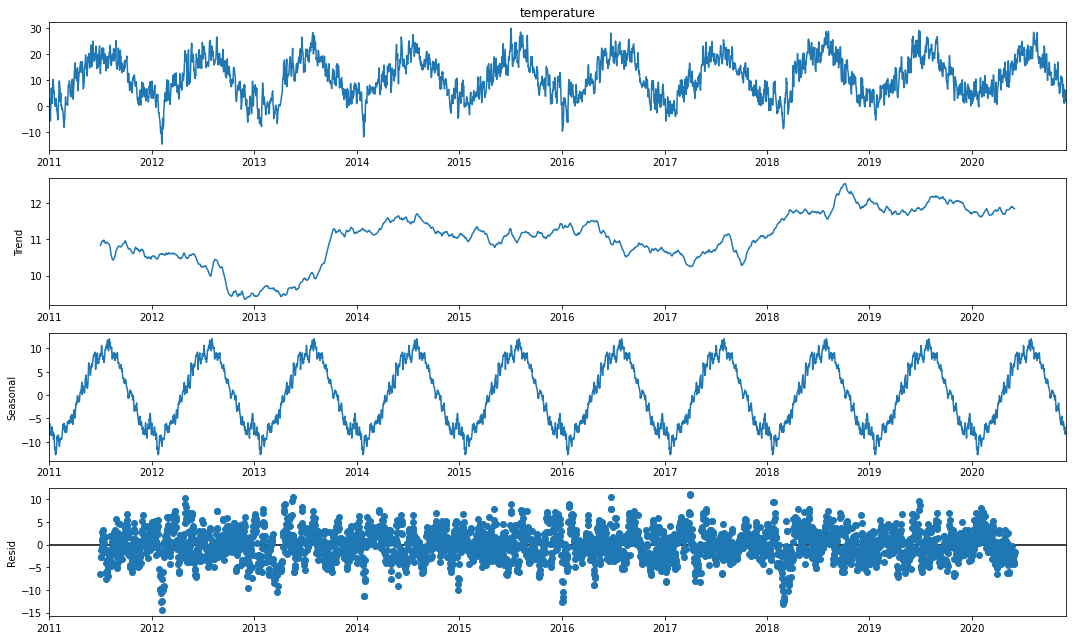

In [38]:
decompose = seasonal_decompose(df['temperature'], model = 'additive', period= 365)
decompose_plot = decompose.plot()

## 6. Stationarity - Statistical tests: ADF, KPSS

### 6.1. Augmented Dickey Fuller Test (ADF)

Null Hypothesis Ho : There is a unit root i.e. the time series is non stationary<br>

Alternate Hypothesis Ha : There is no unit root i.e. the time series is stationary

In [39]:
X = df['temperature'].values
result = statsmodels.tsa.stattools.adfuller(X)
print('ADF: %f' % result[0])
print('p-value: %.15f' % result[1])
print('usedlag: %f' % result[2])
print('nobs: %f' % result[3])
print('information criterion (AIC): %f' % result[5])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF: -4.106475
p-value: 0.000944929284407
usedlag: 15.000000
nobs: 3606.000000
information criterion (AIC): 15681.092315
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**Conclusion:** 

the p value (0.0008) is less than 0.05, thus we reject the Null Hypothesis. ADF: -4.146240 < -3.432, thus we can reject the null hypothesis with a confidence level of 99%. Therefore, the series has no unit root and is stationary. 

### 6.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test) :

Null Hypothesis: The process is trend stationary.<br>

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [40]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [41]:
kpss_test(df['temperature'].values)

Results of KPSS Test:
Test Statistic            0.154698
p-value                   0.100000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**Conclusion:**

Here, the p value is greater than 0.05. we fail to reject the Null Hypothesis and conclude that the series is stationary.

### 6.3. Conclusion 

Both tests conclude stationarity. Therefore, the series is stationary. No differentiation is necessarry. 

## 7. ARIMA model 

### 7.1. Approach 1: Determining parameters manually by looking ACF and PACF

#### 7.1.1 Plotting ACF and PACF 

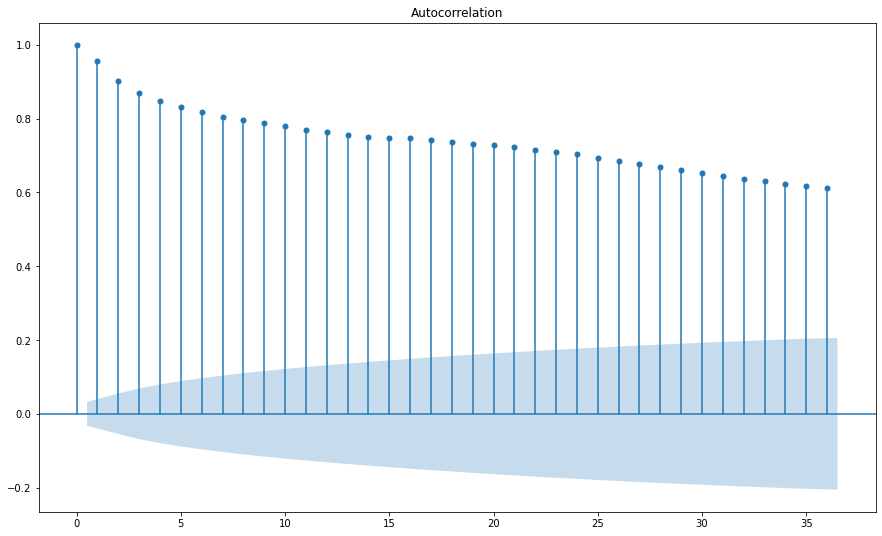

In [42]:
# plotting autocorrelation (x= nr of legs, y= correlaction between legs) 
plot_acf(df['temperature']);

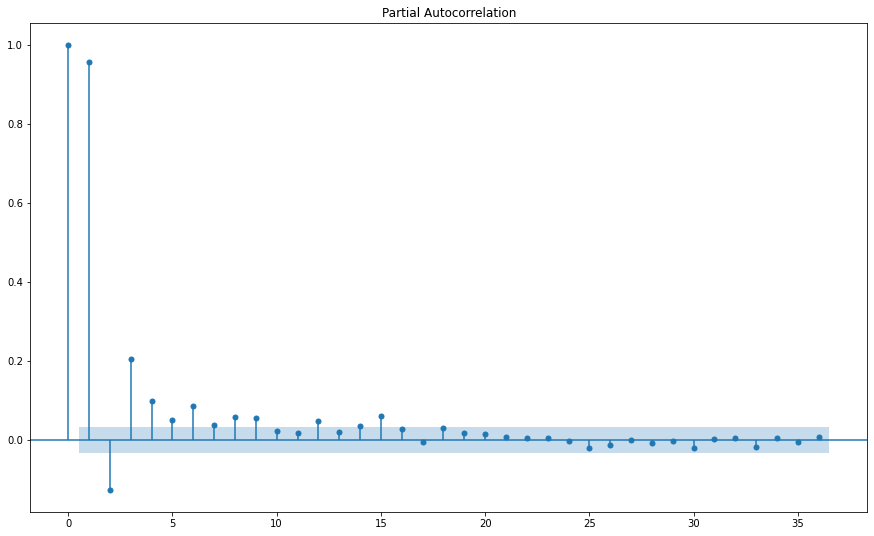

In [43]:
# plotting partial autocorrelation
plot_pacf(df['temperature']);

### 7.1.2. AR and MA: Interpreting the ACF-plot and the PACF-plot:

#### AR process:

If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot. 

p = 2 

#### MA process:

If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot. 


q= ? (ACF plot does not show a drop, lags decrease steadily, PACF plot does not show slow decay)

#### ARIMA process:

If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually we would use an iterative approach and try different combinations to find the best model.

#### Integrated(I)

Integrating a time series is an alternative way to model a trend of the time series. It is basically, differencing the trend. By obvious, on the plot visible linear trend, I is 1. No trend 0. Since we concluded that the series is stationary, we dont need difference the trend:

 d = 0.

### 7.2 Approach 2: parameter optimization with Auto Arima 

#### 7.2.1. Downsizing training data to decrease testing time

In [44]:
df = pd.DataFrame(df['temperature'])

In [45]:
size = int(len(df) * 0.8)
size

2897

In [46]:
df_train = df[:size]
df_test = df[size:]

In [47]:
df_train

,temperature
date,
2011-01-01,2.7
2011-01-02,0.6
2011-01-03,-1.5
2011-01-04,-1.6
2011-01-05,-5.8
...,...
2018-12-02,6.4
2018-12-03,11.0
2018-12-04,6.7


In [48]:
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html 
model_pmdarima = pm.auto_arima(df_train, max_p=10, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12648.874, Time=2.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20110.111, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12881.585, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17034.537, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23268.898, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12755.071, Time=1.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12793.718, Time=1.80 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12647.997, Time=3.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12654.581, Time=2.64 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=12658.579, Time=4.07 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=12644.767, Time=4.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=12646.773, Time=2.96 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=12646.655, Time=5.62 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=12646.635, Time=5.85 sec
 ARIMA(2,0,4)(0,0,0

In [49]:
print(model_pmdarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2897
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -6314.384
Date:                Thu, 03 Mar 2022   AIC                          12644.767
Time:                        00:17:24   BIC                          12692.539
Sample:                             0   HQIC                         12661.981
                               - 2897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0656      0.026      2.483      0.013       0.014       0.117
ar.L1          0.9015      0.185      4.873      0.000       0.539       1.264
ar.L2          0.4769      0.307      1.554      0.1

## 8. Training Arima model

In [50]:
model = ARIMA(df, order=(3, 0, 3)) # instanciation

model_fit = model.fit() # fit 

# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 3622
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7902.546
Date:                Thu, 03 Mar 2022   AIC                          15821.092
Time:                        00:17:29   BIC                          15870.650
Sample:                    01-01-2011   HQIC                         15838.748
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6604      1.737      6.139      0.000       7.257      14.064
ar.L1          0.9091      0.182      5.009      0.000       0.553       1.265
ar.L2          0.4229      0.296      1.430      0.1

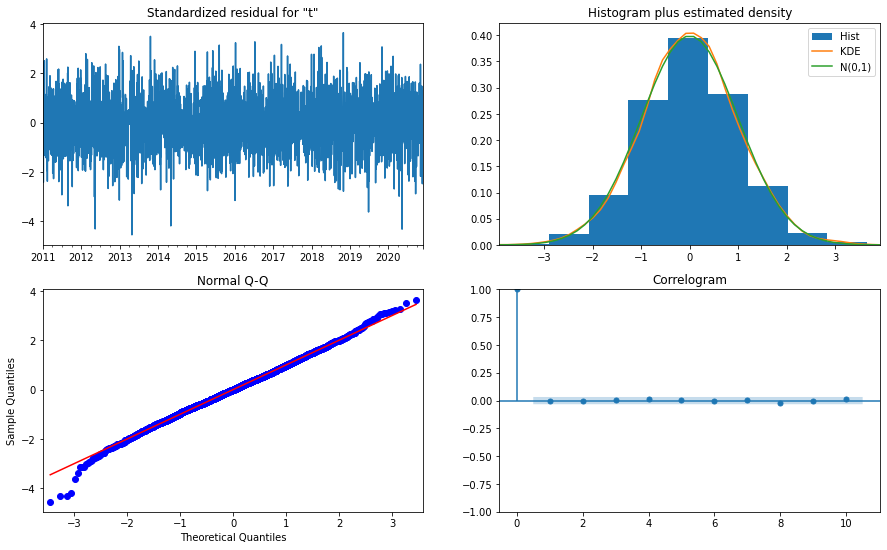

In [51]:
model_fit.plot_diagnostics();

In [52]:
model_fit.resid

date
2011-01-01   -7.960389
2011-01-02   -2.448398
2011-01-03   -2.326649
2011-01-04   -0.696830
2011-01-05   -5.231879
                ...   
2020-11-26    2.091247
2020-11-27    0.589893
2020-11-28   -3.001497
2020-11-29   -1.595322
2020-11-30   -0.823572
Length: 3622, dtype: float64

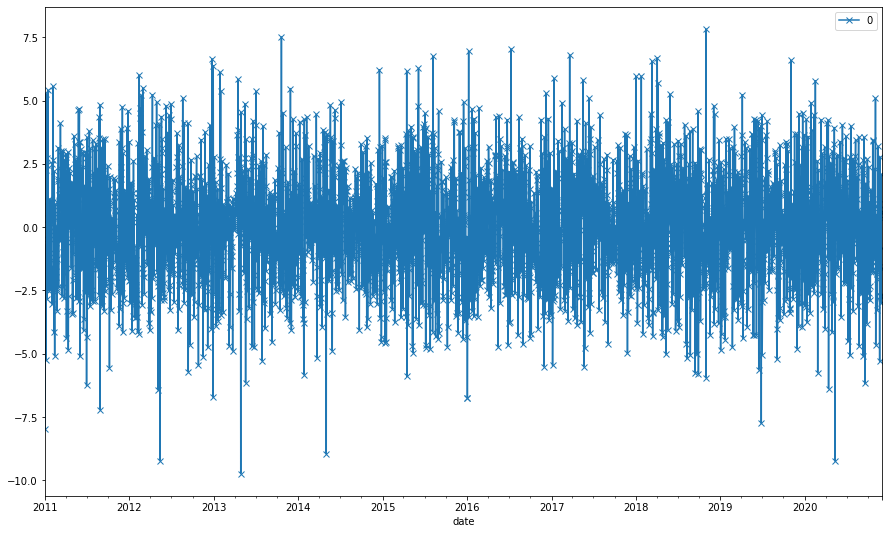

In [53]:
# visualizing the residuals in order to see if there is still a trend or seasonality not captured in the model
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(marker='x')
plt.show()

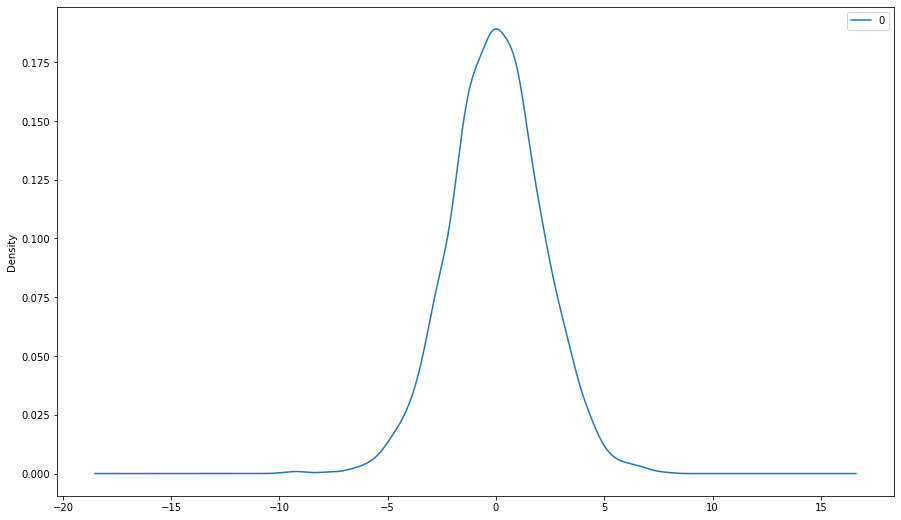

In [54]:
# density plot of residuals: appears to be centered at a value slightly higher than zero, but the shape is Gaussian

residuals.plot(kind='kde')
plt.show()

In [55]:
# summary stats of residuals. closer the mean to the 0, the better the model. 
print(residuals.describe())

                 0
count  3622.000000
mean      0.007745
std       2.147798
min      -9.735625
25%      -1.366395
50%      -0.003635
75%       1.379790
max       7.835339


## 9. Prediction

In [56]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = model_fit.predict(start=start, end=end,  dynamic=False, typ='levels').rename('Predictions')

In [57]:
df_predictions = df[start:end+1]

In [58]:
df_predictions['predictions'] = predictions

In [59]:
fig_prediction = go.Figure()

fig_prediction.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions['temperature'], name='Temperature'))
fig_prediction.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions['predictions'], name='Predictions'))
fig_prediction.update_layout(title_text='Predictions with ARIMA (3,0,3) between 01.01.2019 and 30.11.2020',
                            title_x=0.5, 
                            height=600, 
                            xaxis_title="Date",
                            yaxis_title="Temperature (Celcius)")
fig_prediction.show()

In [60]:
rmse = mean_squared_error(df_predictions['temperature'], df_predictions['predictions'], squared=False)
mape = mean_absolute_percentage_error(df_predictions['temperature'], df_predictions['predictions'])
mae = mean_absolute_error(df_predictions['temperature'], df_predictions['predictions'])
print("RMSE score:", round(rmse, 2))
print("MAE score:", round(mae, 2))

RMSE score: 2.16
MAE score: 1.72


## 10. Forecast

In [61]:
df_forecast = df_forecast[:7]

In [62]:
# forcasting temperature for the upcoming 7 days
forecast_7 = model_fit.forecast(7)

In [63]:
df_forecast['forecast'] = forecast_7

In [64]:
fig_forecast = go.Figure()

fig_forecast.add_trace(go.Scatter(x=df_forecast.index, y=df_forecast['temperature'], name='Temperature'))
fig_forecast.add_trace(go.Scatter(x=df_forecast.index, y=df_forecast['forecast'], name='Forecast'))
fig_forecast.update_layout(title_text='Forecast with ARIMA (3,0,3) for the upcoming week',
                            title_x=0.5, 
                            height=600, 
                            xaxis_title="Date",
                            yaxis_title="Temperature (Celcius)")
fig_forecast.show()

In [65]:
# mape : mean absolute percentage error, the average error in percentage terms.
rmse = mean_squared_error(df_forecast['temperature'], df_forecast['forecast'], squared=False)
mape = mean_absolute_percentage_error(df_forecast['temperature'], df_forecast['forecast'])
mae = mean_absolute_error(df_forecast['temperature'], df_forecast['forecast'])
print("RMSE score:", round(rmse, 2))
print("MAPE score:", round(mape, 2))
print("MAE score:", round(mae, 2))


RMSE score: 2.94
MAPE score: 2.01
MAE score: 2.47
